## MODEL1 ARIMA

### 导包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

#pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #自相关图、偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF #平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
import statsmodels.api as sm #D-W检验,一阶自相关检验
from statsmodels.graphics.api import qqplot #画QQ图,检验一组数据是否服从正态分布
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

### 一、导入数据

- 项目量

In [32]:
df = pd.read_csv('./项目量.csv', index_col=[0], parse_dates=[0])
df.head()
dataset = df['Assign']
dataset.head()
dataset.tail()

,Amount,Assign,ym
date,,,
2017-07-01,207,51,201707
2017-07-02,159,50,201707
2017-07-03,168,55,201707
2017-07-04,168,45,201707
2017-07-05,171,43,201707


date
2017-07-01    51
2017-07-02    50
2017-07-03    55
2017-07-04    45
2017-07-05    43
Name: Assign, dtype: int64

date
2020-10-27    66
2020-10-28    43
2020-10-29    32
2020-10-30    45
2020-10-31    43
Name: Assign, dtype: int64

- 五城-北京

In [113]:
df = pd.read_csv('./五城接单量.csv', index_col=[0], parse_dates=[0], encoding = 'GBK')
df.head()
dataset = df['北京-实派']
dataset.head()
dataset.tail()

,北京-实派,北京-应派,大连-实派,大连-应派,广州-实派,广州-应派,合肥-实派,合肥-应派,苏州-实派,苏州-应派
stat_date,,,,,,,,,,
2017-01-01,80,210,31,63,32,51,57,114,42,51
2017-01-02,70,204,53,45,15,36,38,156,51,42
2017-01-03,81,342,63,87,12,63,81,171,45,60
2017-01-04,76,249,41,57,18,42,56,126,49,69
2017-01-05,81,357,45,72,25,63,56,156,49,87


stat_date
2017-01-01    80
2017-01-02    70
2017-01-03    81
2017-01-04    76
2017-01-05    81
Name: 北京-实派, dtype: int64

stat_date
2020-10-27    253
2020-10-28    261
2020-10-29    182
2020-10-30    191
2020-10-31    213
Name: 北京-实派, dtype: int64

- 降采样

In [87]:
df = pd.read_csv('./五城接单量.csv', index_col=[0], parse_dates=[0], encoding = 'GBK')
df.head()
dataset = df['北京-实派']
dataset.head()
dataset.tail()
dataset = dataset.resample('M').sum()
dataset.head()
dataset.tail()
len(dataset)

,北京-实派,北京-应派,大连-实派,大连-应派,广州-实派,广州-应派,合肥-实派,合肥-应派,苏州-实派,苏州-应派
stat_date,,,,,,,,,,
2017-01-01,80,210,31,63,32,51,57,114,42,51
2017-01-02,70,204,53,45,15,36,38,156,51,42
2017-01-03,81,342,63,87,12,63,81,171,45,60
2017-01-04,76,249,41,57,18,42,56,126,49,69
2017-01-05,81,357,45,72,25,63,56,156,49,87


stat_date
2017-01-01    80
2017-01-02    70
2017-01-03    81
2017-01-04    76
2017-01-05    81
Name: 北京-实派, dtype: int64

stat_date
2020-10-27    253
2020-10-28    261
2020-10-29    182
2020-10-30    191
2020-10-31    213
Name: 北京-实派, dtype: int64

stat_date
2017-01-31     874
2017-02-28    3849
2017-03-31    7431
2017-04-30    7748
2017-05-31    7678
Freq: M, Name: 北京-实派, dtype: int64

stat_date
2020-06-30    6142
2020-07-31    7479
2020-08-31    7261
2020-09-30    7136
2020-10-31    8291
Freq: M, Name: 北京-实派, dtype: int64

46

### 二、原始序列的检验

<Figure size 720x360 with 0 Axes>

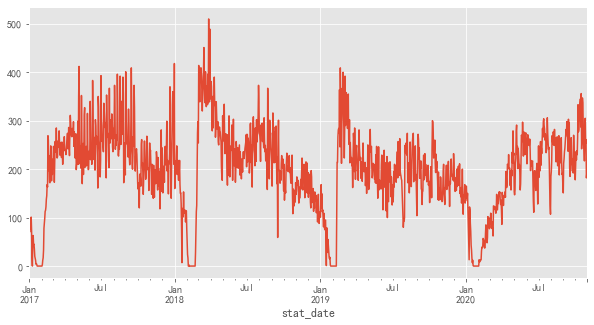

In [114]:
plt.figure(figsize=(10,5))
dataset.plot()
plt.show()

- 平稳性

In [115]:
def teststationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
teststationarity(dataset)

Test Statistic                   -5.081843
p-value                           0.000015
#Lags Used                       21.000000
Number of Observations Used    1378.000000
Critical Value (1%)              -3.435104
Critical Value (5%)              -2.863640
Critical Value (10%)             -2.567888
dtype: float64

- 自相关图 

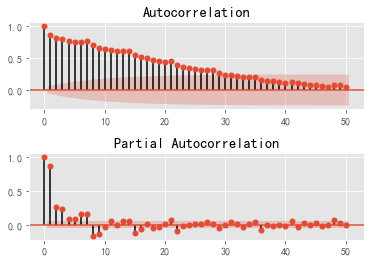

In [116]:
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
draw_acf_pacf(dataset,50)

- 差分

stat_date
2017-01-01     NaN
2017-01-02   -10.0
2017-01-03    11.0
2017-01-04    -5.0
2017-01-05     5.0
              ... 
2020-10-27   -52.0
2020-10-28     8.0
2020-10-29   -79.0
2020-10-30     9.0
2020-10-31    22.0
Name: 北京-实派, Length: 1400, dtype: float64


Test Statistic                -8.398724e+00
p-value                        2.261687e-13
#Lags Used                     2.000000e+01
Number of Observations Used    1.378000e+03
Critical Value (1%)           -3.435104e+00
Critical Value (5%)           -2.863640e+00
Critical Value (10%)          -2.567888e+00
dtype: float64

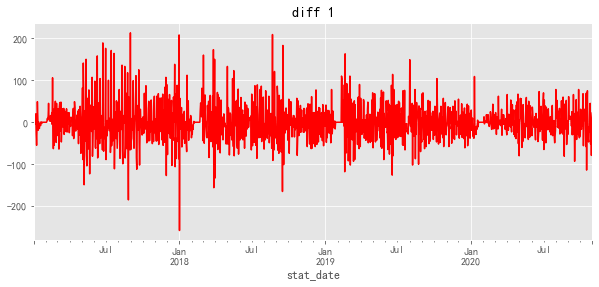

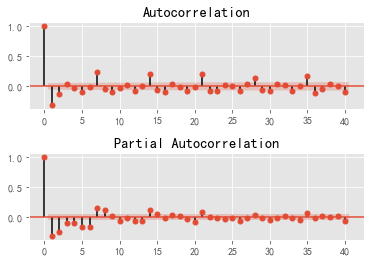

In [117]:
ts_diff_1 = dataset.diff(1)
print(ts_diff_1)
ts_diff_1.dropna(inplace=True)
teststationarity(ts_diff_1)
ts_diff_1.plot(color = 'red',title='diff 1',figsize=(10,4))
draw_acf_pacf(ts_diff_1,40)

- 参数调优：BIC

In [120]:
pmax=int(len(dataset)/200) #一般阶数不超过length/10
qmax=int(len(dataset)/200) #一般阶数不超过length/10
pmax
qmax

7

7

In [121]:
bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(dataset,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix=pd.DataFrame(bic_matrix)
print(bic_matrix)
print(bic_matrix.stack())
p,q=bic_matrix.stack().idxmin() #最小值的索引
print('用BIC方法得到最优的p值是%d,q值是%d'%(p,q))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

              0             1             2             3             4  \
0  16470.166725  15537.351511  15191.521685  14964.924331  14775.892550   
1  14574.706262  14397.795448  14377.910861  14384.349686  14391.321495   
2  14479.454126  14381.521759  14384.197050  14384.211459  14391.416334   
3  14413.516614  14385.187129  14385.332442  14391.418891  14367.004427   
4  14410.056999  14392.146334  14391.397755  14334.252512  14331.418776   
5  14408.342792  14392.364880  14317.009916  14317.796003  14312.964707   
6  14378.356191  14374.319056  14312.222555  14317.452152  14286.308012   
7  14347.554747  14339.858367  14319.390740  14320.183838  14264.331254   

              5             6             7  
0  14730.147055  14737.081494  14642.713472  
1  14396.581486  14376.598530  14346.021303  
2  14389.481460  14373.118342  14346.921447  
3  14337.076257  14328.176272  14346.636175  
4  14329.890412  14331.815418  14351.148641  
5  14262.481071  14267.129703  14273.541953  
6 

### 三、建模及预测

- 测试集与训练集划分

In [135]:
# train_size = int(len(dataset) * 0.9)
# trainlist = dataset[:train_size]
# testlist = dataset[train_size:]
trainlist = dataset[:-45]
testlist = dataset[-45:]
print(type(trainlist))
trainlist = trainlist.astype('float64') 

<class 'pandas.core.series.Series'>


- 训练集模型训练

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


stat_date
2020-09-12    266.0
2020-09-13    237.0
2020-09-14    303.0
2020-09-15    281.0
2020-09-16    296.0
Name: 北京-实派, dtype: float64
2017-01-07    -5.295237
2017-01-08   -11.307009
2017-01-09    23.536351
2017-01-10    32.723460
2017-01-11    -9.316733
                ...    
2020-09-12     1.347151
2020-09-13     4.886428
2020-09-14    15.835839
2020-09-15   -23.843018
2020-09-16     5.167197
Freq: D, Length: 1349, dtype: float64


Text(0.5, 1.0, 'RMSE: 219.0377')

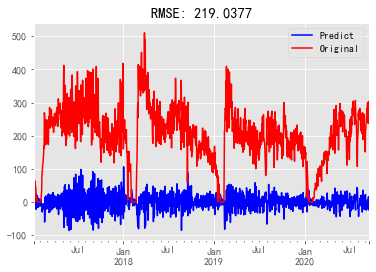

In [136]:
model = ARIMA(trainlist, order=(5, 1, 5))
print(trainlist.tail())
results = model.fit( disp=-1, method='css')
predict = results.predict()
ts = trainlist[predict.index]  
print(predict)
predict.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predict-ts)**2)/ts.size))
plt.show()

- 预测测试集

stat_date
2020-09-17    203
2020-09-18    185
2020-09-19    207
2020-09-20    211
2020-09-21    265
2020-09-22    224
2020-09-23    218
2020-09-24    196
2020-09-25    220
2020-09-26    192
2020-09-27    270
2020-09-28    239
2020-09-29    202
2020-09-30    211
2020-10-01    178
2020-10-02    209
2020-10-03    236
2020-10-04    219
2020-10-05    238
2020-10-06    230
2020-10-07    265
2020-10-08    333
2020-10-09    277
2020-10-10    281
2020-10-11    301
2020-10-12    332
2020-10-13    336
2020-10-14    345
2020-10-15    287
2020-10-16    356
2020-10-17    242
2020-10-18    272
2020-10-19    347
2020-10-20    337
2020-10-21    298
2020-10-22    251
2020-10-23    239
2020-10-24    217
2020-10-25    260
2020-10-26    305
2020-10-27    253
2020-10-28    261
2020-10-29    182
2020-10-30    191
2020-10-31    213
Name: 北京-实派, dtype: int64
(array([295.76089344, 286.85896908, 276.61635945, 280.27597607,
       286.4262324 , 287.34773135, 291.91716185, 295.25135575,
       286.62178244, 278.49

<Figure size 432x432 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

44440.338093617334
11334
stat_date
2020-09-12    266.0
2020-09-13    237.0
2020-09-14    303.0
2020-09-15    281.0
2020-09-16    296.0
Name: 北京-实派, dtype: float64


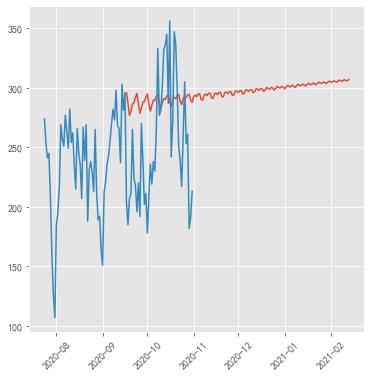

In [141]:
print(testlist)
print(results.forecast(len(testlist)))
forecast=pd.Series(results.forecast(150)[0],index=pd.date_range('2020-09-17',periods=150,freq='D'))
plt.figure(figsize=(6, 6))
plt.xticks(rotation=45)
plt.plot(forecast)
plt.plot(dataset[-100:])
print(forecast.sum())
print(testlist.sum())
print(trainlist.tail())

- 残差检验

<ipython-input-129-d9b68b5d3222>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(resid,lags=35).show()
<ipython-input-129-d9b68b5d3222>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(resid,lags=20).show()
<ipython-input-129-d9b68b5d3222>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(resid,lags=35).show()


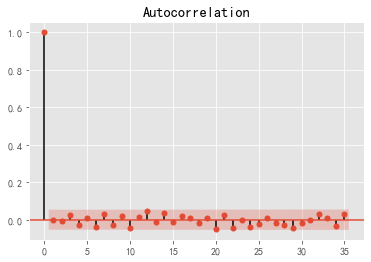

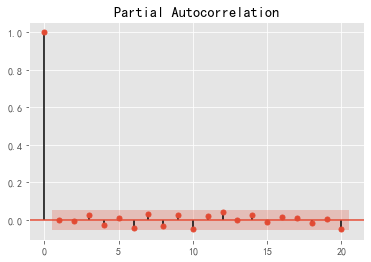

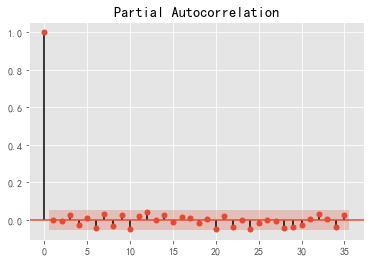

In [129]:
resid=results.resid

#自相关图
plot_acf(resid,lags=35).show()


#偏自相关图
plot_pacf(resid,lags=20).show()

#偏自相关图
plot_pacf(resid,lags=35).show()

- QQ图

<ipython-input-130-43b24c673058>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqplot(resid, line='q', fit=True).show()


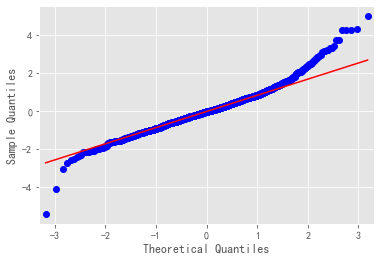

In [130]:
qqplot(resid, line='q', fit=True).show() 

## MODEL2 LSTM

### 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
#读取数据
df = pd.read_csv('./五城接单量.csv', index_col=[0], parse_dates=[0], encoding = 'GBK')
df.head()
data = df['北京-实派']
data.head()
data.tail()
dataf = data.values[0:-36]
dataf

array([ 80,  70,  81, ..., 218, 196, 220], dtype=int64)

In [9]:
def create_dataset(dataset, timesteps=36,predict_size=6):#构造数据集
    datax=[]#构造x
    datay=[]#构造y
    for each in range(len(dataset)-timesteps - predict_steps):
        x = dataset[each:each+timesteps,0]
        y = dataset[each+timesteps:each+timesteps+predict_steps,0]
        datax.append(x)
        datay.append(y)
    return datax, datay#np.array(datax),np.array(datay)

In [10]:
#构造train and predict
scaler = MinMaxScaler(feature_range=(0,1))
dataf = scaler.fit_transform(dataf.reshape(-1, 1))
train = dataf.copy()
timesteps = 100#构造x，为72个数据,表示每次用前72个数据作为一段
predict_steps = 36#构造y，为12个数据，表示用后12个数据作为一段
length = 36#预测多步，
trainx, trainy = create_dataset(train, timesteps, predict_steps)
trainx = np.array(trainx)
trainy = np.array(trainy)
print(trainx)
print(trainy)

[[0.15686275 0.1372549  0.15882353 ... 0.4745098  0.49607843 0.56078431]
 [0.1372549  0.15882353 0.14901961 ... 0.49607843 0.56078431 0.48431373]
 [0.15882353 0.14901961 0.15882353 ... 0.56078431 0.48431373 0.44705882]
 ...
 [0.39411765 0.47647059 0.44901961 ... 0.52156863 0.48235294 0.46078431]
 [0.47647059 0.44901961 0.41568627 ... 0.48235294 0.46078431 0.40588235]
 [0.44901961 0.41568627 0.40980392 ... 0.46078431 0.40588235 0.52352941]]
[[0.48431373 0.44705882 0.54313725 ... 0.33333333 0.44509804 0.49607843]
 [0.44705882 0.54313725 0.60980392 ... 0.44509804 0.49607843 0.37058824]
 [0.54313725 0.60980392 0.58039216 ... 0.49607843 0.37058824 0.46078431]
 ...
 [0.40588235 0.52352941 0.46862745 ... 0.41372549 0.51960784 0.43921569]
 [0.52352941 0.46862745 0.52745098 ... 0.51960784 0.43921569 0.42745098]
 [0.46862745 0.52745098 0.36862745 ... 0.43921569 0.42745098 0.38431373]]


In [11]:
#变换
trainx = np.reshape(trainx,(trainx.shape[0],timesteps,1))#变换shape,以满足keras
#lstm training
model = Sequential()
model.add(LSTM(128,input_shape=(timesteps,1),return_sequences= True))
model.add(Dropout(0.5))
model.add(LSTM(128,return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(64,return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(predict_steps))
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(trainx,trainy, epochs= 100, batch_size=200)

Epoch 1/100
7/7 [==============================] - 4s 614ms/step - loss: 0.1426
Epoch 2/100
7/7 [==============================] - 3s 479ms/step - loss: 0.0462
Epoch 3/100
7/7 [==============================] - 3s 451ms/step - loss: 0.0295
Epoch 4/100
7/7 [==============================] - 3s 449ms/step - loss: 0.0274
Epoch 5/100
7/7 [==============================] - 3s 466ms/step - loss: 0.0257
Epoch 6/100
7/7 [==============================] - 3s 455ms/step - loss: 0.0250
Epoch 7/100
7/7 [==============================] - 3s 458ms/step - loss: 0.0244
Epoch 8/100
7/7 [==============================] - 3s 456ms/step - loss: 0.0243
Epoch 9/100
7/7 [==============================] - 3s 456ms/step - loss: 0.0233
Epoch 10/100
7/7 [==============================] - 3s 453ms/step - loss: 0.0228
Epoch 11/100
7/7 [==============================] - 3s 458ms/step - loss: 0.0224
Epoch 12/100
7/7 [==============================] - 3s 458ms/step - loss: 0.0225
Epoch 13/100
7/7 [===================

[222.16615, 209.68504, 221.30888, 218.155, 222.28168, 208.96565, 218.18835, 215.31519, 210.52014, 216.26793, 207.6329, 205.54353, 204.4453, 208.18668, 212.2861, 204.47914, 206.99461, 210.47755, 203.5423, 204.91908, 211.4036, 207.76965, 202.18665, 203.18103, 203.81798, 202.44931, 207.2964, 204.77335, 198.07695, 206.70917, 209.67223, 195.20084, 199.6491, 201.87782, 206.15034, 203.16547]
train score RMSE: 74.99


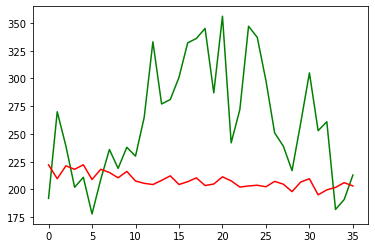

9405
7494.7410888671875


In [12]:

predict_xlist = []#添加预测x列表
predict_y = []#添加预测y列表
predict_xlist.extend(dataf[dataf.shape[0]-timesteps:dataf.shape[0]].tolist())#已经存在的最后timesteps个数据添加进列表，预测新值(比如已经有的数据从1,2,3到288。现在要预测后面的数据，所以将216到288的72个数据添加到列表中，预测新的值即288以后的数据）
# print(dataf.shape[0])
# print(dataf)
while len(predict_y) < length:
    predictx = np.array(predict_xlist[-timesteps:])#从最新的predict_xlist取出timesteps个数据，预测新的predict_steps个数据（因为每次预测的y会添加到predict_xlist列表中，为了预测将来的值，所以每次构造的x要取这个列表中最后的timesteps个数据词啊性）
    #print("predictx"),print(predictx),print(predictx.shape)
    predictx = np.reshape(predictx,(1,timesteps,1))#变换格式，适应LSTM模型
    #预测新值
    lstm_predict = model.predict(predictx)
    #predict_list.append(train_predict)#新值y添加进列表，做x
    #滚动预测
    predict_xlist.extend(np.reshape(lstm_predict[0],(predict_steps,1)))#将新预测出来的predict_steps个数据，加入predict_xlist列表，用于下次预测
    # invert
    lstm_predict = scaler.inverse_transform(lstm_predict)
    predict_y.extend(lstm_predict[0])#预测的结果y，每次预测的12个数据，添加进去，直到预测288个为止
    #print("xlist", predict_xlist, len(predict_xlist))
    #print(lstm_predict, len(lstm_predict))
    #print(predict_y, len(predict_y))
#error
print(predict_y)
y_ture = np.array(data.values[-36:])
train_score = np.sqrt(mean_squared_error(y_ture,predict_y))
print("train score RMSE: %.2f"% train_score)
y_predict = pd.DataFrame(predict_y,columns=["predict"])
plt.plot(y_ture,c="g")
plt.plot(predict_y, c="r")
plt.show()
print(y_ture.sum())
print(sum(predict_y))


In [31]:
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], [ ] 
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
#读取数据
df = pd.read_csv('./五城接单量.csv', index_col=[0], parse_dates=[0], encoding = 'GBK')
df.head()
dataframe = df['北京-实派']
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainY)
print(testY)
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: ', testScore)



938 462
[ 70.  81.  76.  81. 101.  72.  17.   0.  49.  63.  44.  45.  35.  20.
  16.  12.   4.   5.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   3.  12.  17.  33.  78.  88.  99. 113. 115. 122.
 138. 145. 168. 163. 269. 260. 197. 228. 173. 172. 198. 248. 224. 176.
 221. 189. 218. 215. 247. 237. 173. 210. 257. 236. 237. 285. 238. 223.
 226. 258. 258. 246. 279. 250. 229. 255. 251. 246. 224. 256. 233. 210.
 232. 249. 244. 267. 242. 238. 240. 230. 242. 253. 264. 274. 242. 253.
 286. 247. 228. 277. 311. 296. 275. 268. 267. 284. 268. 271. 298. 247.
 277. 246. 223. 261. 273. 199. 210. 210. 217. 299. 210. 351. 412. 263.
 211. 219. 247. 202. 352. 274. 170. 227. 253. 189. 235. 312. 327. 204.
 218. 206. 247. 230. 208. 315. 234. 199. 200. 237. 221. 242. 340. 281.
 219. 249. 210. 225. 383. 298. 220. 266. 231. 249. 198. 302. 289. 252.
 268. 247. 227. 161. 350. 329. 260. 248. 223. 184. 217. 393. 304. 290.
 257. 261. 250. 236. 336. 324. 304. 286. 296. 224. 182. 353. 297. 267

468/468 - 0s - loss: 2470.5054
Epoch 27/200
468/468 - 0s - loss: 2474.3115
Epoch 28/200
468/468 - 0s - loss: 2457.8899
Epoch 29/200
468/468 - 0s - loss: 2470.3147
Epoch 30/200
468/468 - 0s - loss: 2468.8550
Epoch 31/200
468/468 - 0s - loss: 2459.5559
Epoch 32/200
468/468 - 0s - loss: 2466.3240
Epoch 33/200
468/468 - 0s - loss: 2469.0596
Epoch 34/200
468/468 - 0s - loss: 2454.2356
Epoch 35/200
468/468 - 0s - loss: 2463.7722
Epoch 36/200
468/468 - 0s - loss: 2457.6958
Epoch 37/200
468/468 - 0s - loss: 2466.7478
Epoch 38/200
468/468 - 0s - loss: 2457.6152
Epoch 39/200
468/468 - 0s - loss: 2457.5625
Epoch 40/200
468/468 - 0s - loss: 2456.3481
Epoch 41/200
468/468 - 0s - loss: 2447.0703
Epoch 42/200
468/468 - 0s - loss: 2467.4036
Epoch 43/200
468/468 - 0s - loss: 2450.1958
Epoch 44/200
468/468 - 0s - loss: 2452.4626
Epoch 45/200
468/468 - 0s - loss: 2450.0835
Epoch 46/200
468/468 - 0s - loss: 2456.7131
Epoch 47/200
468/468 - 0s - loss: 2435.9497
Epoch 48/200
468/468 - 0s - loss: 2453.2632
E

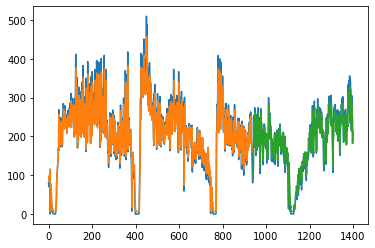

In [29]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict[:,0]

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict[:,0]

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## MODEL3 周期性序列预测

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import style #自定义图表风格
style.use('ggplot')

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

#pip install statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  #自相关图、偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF #平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox #白噪声检验
import statsmodels.api as sm #D-W检验,一阶自相关检验
from statsmodels.graphics.api import qqplot #画QQ图,检验一组数据是否服从正态分布
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
#读取数据
df = pd.read_csv('./五城接单量.csv', index_col=[0], parse_dates=[0], encoding = 'GBK')
df.head()
ts = df['合肥-实派']
# dataset = dataframe.values
# ts = dataset.astype('float32')
test_size = 30
train_size = len(ts) - test_size
train = ts[:len(ts)-test_size]
test = ts[-test_size:]

,北京-实派,北京-应派,大连-实派,大连-应派,广州-实派,广州-应派,合肥-实派,合肥-应派,苏州-实派,苏州-应派
stat_date,,,,,,,,,,
2017-01-01,80,210,31,63,32,51,57,114,42,51
2017-01-02,70,204,53,45,15,36,38,156,51,42
2017-01-03,81,342,63,87,12,63,81,171,45,60
2017-01-04,76,249,41,57,18,42,56,126,49,69
2017-01-05,81,357,45,72,25,63,56,156,49,87


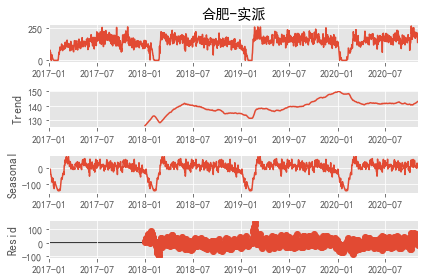

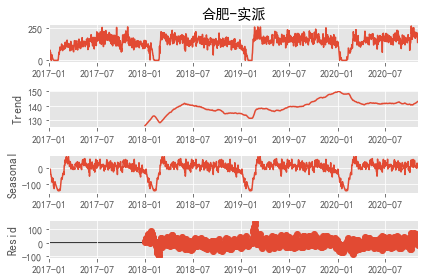

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=364, two_sided=False)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()
trend.dropna(inplace=True)

In [11]:
def teststationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
teststationarity(trend)

Test Statistic                   -1.018754
p-value                           0.746363
#Lags Used                       22.000000
Number of Observations Used    1013.000000
Critical Value (1%)              -3.436822
Critical Value (5%)              -2.864397
Critical Value (10%)             -2.568291
dtype: float64

stat_date
2017-12-31         NaN
2018-01-01    0.219178
2018-01-02    0.402740
2018-01-03    0.328767
2018-01-04    0.364384
                ...   
2020-10-27    0.317808
2020-10-28    0.210959
2020-10-29    0.000000
2020-10-30    0.106849
2020-10-31    0.194521
Name: trend, Length: 1036, dtype: float64


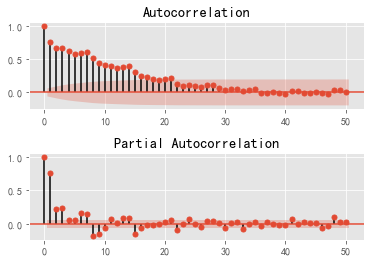

Test Statistic                   -5.062683
p-value                           0.000017
#Lags Used                       21.000000
Number of Observations Used    1013.000000
Critical Value (1%)              -3.436822
Critical Value (5%)              -2.864397
Critical Value (10%)             -2.568291
dtype: float64

In [12]:
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()
trend_diff = trend.diff(1)
print(trend_diff)
trend_diff.dropna(inplace=True)
draw_acf_pacf(trend_diff,50)
teststationarity(trend_diff)

In [4]:
pmax = 7
qmax = 7
bic_matrix=[]
for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(trend,(p,0,q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix=pd.DataFrame(bic_matrix)
p,q=bic_matrix.stack().idxmin() #最小值的索引
print('用BIC方法得到最优的p值是%d,q值是%d'%(p,q))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency inform

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimiza

TypeError: reduction operation 'argmin' not allowed for this dtype

In [13]:
train = trend[:len(trend)-test_size]
trend_model = ARIMA(train,order=(3, 0, 1)).fit(disp=-1, method='css')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [14]:
n = test_size
pred_time_index= pd.date_range(start=train.index[-1], periods=n+1, freq='D')[1:]
trend_pred= trend_model.forecast(n)[0]

In [15]:
d = residual.describe()
delta = d['75%'] - d['25%']
low_error, high_error = (d['25%'] - 1 * delta, d['75%'] + 1 * delta)

In [16]:
train_season = seasonal[:train_size]
values = []
low_conf_values = []
high_conf_values = []
print(train_season.index)
for i, t in enumerate(pred_time_index):
    trend_part = trend_pred[i]
    # 相同时间点的周期数据均值
#     print(pd.to_datetime(train_season.index)), print(pd.DatetimeIndex([t.date()]))
    season_part = train_season[train_season.index.strftime("%m-%d") == pd.DatetimeIndex([t.date()])[0].strftime("%m-%d")].mean()
    print(train_season)
    # 趋势 + 周期 + 误差界限
    predict = trend_part + season_part
    low_bound = trend_part + season_part + low_error
    high_bound = trend_part + season_part + high_error
    values.append(predict)
    low_conf_values.append(low_bound)
    high_conf_values.append(high_bound)
# 得到预测值，误差上界和下界
final_pred = pd.Series(values, index=pred_time_index, name='predict')
low_conf = pd.Series(low_conf_values, index=pred_time_index, name='low_conf')
high_conf = pd.Series(high_conf_values, index=pred_time_index, name='high_conf')

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01'],
              dtype='datetime64[ns]', name='stat_date', length=1370, freq=None)
stat_date
2017-01-01   -24.694085
2017-01-02   -33.102510
2017-01-03   -11.836026
2017-01-04   -32.892803
2017-01-05    -4.625862
                ...    
2020-09-27     0.222124
2020-09-28   -15.191796
2020-09-29     6.731739
2020-09-30    -0.347016
2020-10-01   -20.709195
Name: seasonal, Length: 1370, dtype: float64
stat_date
2017-01-01   -24.694085
2017-01-02   -33.102510
2017-01-03   -11.836026
2017-01-04   -32.892803
2017-01-05    -4.625862
                ...    
2020-09-27     0.222124
2020-09-28   -15.191796
2020-09-2

2020-10-02    138.037714
2020-10-03    136.108367
2020-10-04    125.456823
2020-10-05    129.200891
2020-10-06    138.207519
2020-10-07    162.223764
2020-10-08    170.784974
2020-10-09    186.086780
2020-10-10    187.806530
2020-10-11    190.747875
2020-10-12    186.822813
2020-10-13    173.033910
2020-10-14    170.030414
2020-10-15    171.903998
2020-10-16    186.750245
2020-10-17    176.259278
2020-10-18    172.894012
2020-10-19    160.984920
2020-10-20    165.958202
2020-10-21    170.706500
2020-10-22    178.135139
2020-10-23    176.462643
2020-10-24    165.365574
2020-10-25    153.280878
2020-10-26    151.420996
2020-10-27    149.649470
2020-10-28    152.516657
2020-10-29    149.824141
2020-10-30    153.460194
2020-10-31    159.648714
Freq: D, Name: predict, dtype: float64


Text(0.5, 1.0, 'RMSE: 44.1909')

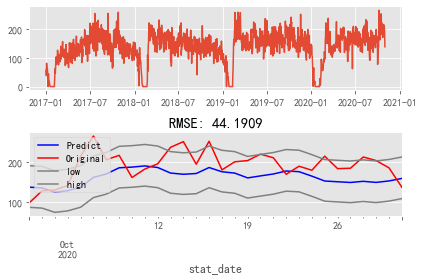

4889.769936033251
5762


In [17]:
pred = final_pred
print(pred)

plt.subplot(211)
plt.plot(ts) # 平滑过的训练数据加未做处理的测试数据

plt.subplot(212)
pred.plot(color='blue', label='Predict') # 预测值
test.plot(color='red', label='Original') # 真实值
low_conf.plot(color='grey', label='low') # 低置信区间
high_conf.plot(color='grey', label='high') # 高置信区间

plt.legend(loc='best')
plt.title('RMSE: %.4f' % np.sqrt(sum((pred.values - test.values) ** 2) / test.size))
plt.tight_layout()
plt.show()

print(pred.sum())
print(sum(test))